<a href="https://colab.research.google.com/github/SubhayanSinha/Content/blob/main/MyCricketWinPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import re
import random

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

In [2]:
# Import dataset from Kaggle
!pip install kaggle
from google.colab import files
files.upload()  # Upload your Kaggle API key (kaggle.json) after downloading from your Kaggle account settings
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d patrickb1912/ipl-complete-dataset-20082020

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/patrickb1912/ipl-complete-dataset-20082020
License(s): DbCL-1.0
  0% 0.00/1.82M [00:00<?, ?B/s]
100% 1.82M/1.82M [00:00<00:00, 85.4MB/s]


In [3]:
!unzip ipl-complete-dataset-20082020.zip

Archive:  ipl-complete-dataset-20082020.zip
  inflating: deliveries.csv          
  inflating: matches.csv             


In [4]:
matches = pd.read_csv('matches.csv')
matches_backup = matches.copy()
balls = pd.read_csv('deliveries.csv')
balls_backup = balls.copy()
matches.tail()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
1090,1426307,2024,Hyderabad,2024-05-19,League,Abhishek Sharma,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Punjab Kings,Sunrisers Hyderabad,Punjab Kings,bat,Sunrisers Hyderabad,wickets,4.0,215.0,20.0,N,NaN,Nitin Menon,VK Sharma
1091,1426309,2024,Ahmedabad,2024-05-21,Qualifier 1,MA Starc,"Narendra Modi Stadium, Ahmedabad",Sunrisers Hyderabad,Kolkata Knight Riders,Sunrisers Hyderabad,bat,Kolkata Knight Riders,wickets,8.0,160.0,20.0,N,NaN,AK Chaudhary,R Pandit
1092,1426310,2024,Ahmedabad,2024-05-22,Eliminator,R Ashwin,"Narendra Modi Stadium, Ahmedabad",Royal Challengers Bengaluru,Rajasthan Royals,Rajasthan Royals,field,Rajasthan Royals,wickets,4.0,173.0,20.0,N,NaN,KN Ananthapadmanabhan,MV Saidharshan Kumar
1093,1426311,2024,Chennai,2024-05-24,Qualifier 2,Shahbaz Ahmed,"MA Chidambaram Stadium, Chepauk, Chennai",Sunrisers Hyderabad,Rajasthan Royals,Rajasthan Royals,field,Sunrisers Hyderabad,runs,36.0,176.0,20.0,N,NaN,Nitin Menon,VK Sharma
1094,1426312,2024,Chennai,2024-05-26,Final,MA Starc,"MA Chidambaram Stadium, Chepauk, Chennai",Sunrisers Hyderabad,Kolkata Knight Riders,Sunrisers Hyderabad,bat,Kolkata Knight Riders,wickets,8.0,114.0,20.0,N,NaN,J Madanagopal,Nitin Menon


In [5]:
print(matches.shape)

(1095, 20)


In [6]:
print(matches.isnull().sum())

id                    0
season                0
city                 51
date                  0
match_type            0
player_of_match       5
venue                 0
team1                 0
team2                 0
toss_winner           0
toss_decision         0
winner                5
result                0
result_margin        19
target_runs           3
target_overs          3
super_over            0
method             1074
umpire1               0
umpire2               0
dtype: int64


In [7]:
print(matches.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1095 non-null   int64  
 1   season           1095 non-null   object 
 2   city             1044 non-null   object 
 3   date             1095 non-null   object 
 4   match_type       1095 non-null   object 
 5   player_of_match  1090 non-null   object 
 6   venue            1095 non-null   object 
 7   team1            1095 non-null   object 
 8   team2            1095 non-null   object 
 9   toss_winner      1095 non-null   object 
 10  toss_decision    1095 non-null   object 
 11  winner           1090 non-null   object 
 12  result           1095 non-null   object 
 13  result_margin    1076 non-null   float64
 14  target_runs      1092 non-null   float64
 15  target_overs     1092 non-null   float64
 16  super_over       1095 non-null   object 
 17  method        

In [8]:
matches[matches['winner'].isna()]

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
241,501265,2011,Delhi,2011-05-21,League,NaN,Feroz Shah Kotla,Delhi Daredevils,Pune Warriors,Delhi Daredevils,bat,NaN,no result,NaN,NaN,NaN,N,NaN,SS Hazare,RJ Tucker
485,829763,2015,Bangalore,2015-04-29,League,NaN,M Chinnaswamy Stadium,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,NaN,no result,NaN,NaN,NaN,N,NaN,JD Cloete,PG Pathak
511,829813,2015,Bangalore,2015-05-17,League,NaN,M Chinnaswamy Stadium,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,field,NaN,no result,NaN,188.0,20.0,N,NaN,HDPK Dharmasena,K Srinivasan
744,1178424,2019,Bengaluru,2019-04-30,League,NaN,M.Chinnaswamy Stadium,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,NaN,no result,NaN,63.0,5.0,N,NaN,NJ Llong,UV Gandhe
994,1359519,2023,Lucknow,2023-05-03,League,NaN,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,Lucknow Super Giants,Chennai Super Kings,Chennai Super Kings,field,NaN,no result,NaN,NaN,NaN,N,NaN,AK Chaudhary,NA Patwardhan


In [9]:
# First Drop the Unwanted Columns
matches.drop(['city','id','method'],axis=1,inplace=True)
matches = matches.dropna()

In [10]:
matches.head()

,season,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,umpire1,umpire2
0,2007/08,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen
1,2007/08,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,MR Benson,SL Shastri
2,2007/08,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar
3,2007/08,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,SJ Davis,DJ Harper
4,2007/08,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,BF Bowden,K Hariharan


In [11]:
# Using pandas library functions to convert the date columns into their respective data types
matches['date'] = pd.to_datetime(matches['date'])

In [12]:
matches['season_begin'] = matches['season'].apply(lambda x: int(x[:4]))
matches['season_end'] = matches['season'].apply(lambda x: int('20'+str(x[5:])) if len(x)>5 else int(x[:4]))

In [13]:
matches.drop('season',axis=1, inplace=True)
matches.head()

,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,season_begin,season_end
0,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,2007,2008
1,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,MR Benson,SL Shastri,2007,2008
2,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar,2007,2008
3,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,SJ Davis,DJ Harper,2007,2008
4,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,BF Bowden,K Hariharan,2007,2008


In [14]:
matches['winner'].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Delhi Daredevils',
       'Royal Challengers Bangalore', 'Rajasthan Royals',
       'Kings XI Punjab', 'Deccan Chargers', 'Mumbai Indians',
       'Pune Warriors', 'Kochi Tuskers Kerala', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Gujarat Titans', 'Lucknow Super Giants',
       'Royal Challengers Bengaluru'], dtype=object)

In [15]:
# Updating the names of the teams as per new names

matches['team1'] = matches['team1'].str.replace('Delhi Daredevils', 'Delhi Capitals')
matches['team2'] = matches['team2'].str.replace('Delhi Daredevils', 'Delhi Capitals')
matches['winner'] = matches['winner'].str.replace('Delhi Daredevils', 'Delhi Capitals')

matches['team1'] = matches['team1'].str.replace('Kings XI Punjab', 'Punjab Kings')
matches['team2'] = matches['team2'].str.replace('Kings XI Punjab', 'Punjab Kings')
matches['winner'] = matches['winner'].str.replace('Kings XI Punjab', 'Punjab Kings')

matches['team1'] = matches['team1'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
matches['team2'] = matches['team2'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
matches['winner'] = matches['winner'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')

matches['team1'] = matches['team1'].str.replace('Rising Pune Supergiant', 'Pune Warriors')
matches['team2'] = matches['team2'].str.replace('Rising Pune Supergiant', 'Pune Warriors')
matches['winner'] = matches['winner'].str.replace('Rising Pune Supergiant', 'Pune Warriors')

matches['team1'] = matches['team1'].str.replace('Rising Pune Supergiants', 'Pune Warriors')
matches['team2'] = matches['team2'].str.replace('Rising Pune Supergiants', 'Pune Warriors')
matches['winner'] = matches['winner'].str.replace('Rising Pune Supergiants', 'Pune Warriors')

matches['team1'] = matches['team1'].str.replace('Gujarat Lions', 'Gujarat Titans')
matches['team2'] = matches['team2'].str.replace('Gujarat Lions', 'Gujarat Titans')
matches['winner'] = matches['winner'].str.replace('Gujarat Lions', 'Gujarat Titans')

In [16]:
matches.head()

,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,season_begin,season_end
0,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,2007,2008
1,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Punjab Kings,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,MR Benson,SL Shastri,2007,2008
2,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Capitals,Rajasthan Royals,Rajasthan Royals,bat,Delhi Capitals,wickets,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar,2007,2008
3,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,SJ Davis,DJ Harper,2007,2008
4,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Sunrisers Hyderabad,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,BF Bowden,K Hariharan,2007,2008


In [17]:
balls.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [18]:
print(balls.shape)

(260920, 17)


In [19]:
print(balls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260920 entries, 0 to 260919
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   match_id          260920 non-null  int64 
 1   inning            260920 non-null  int64 
 2   batting_team      260920 non-null  object
 3   bowling_team      260920 non-null  object
 4   over              260920 non-null  int64 
 5   ball              260920 non-null  int64 
 6   batter            260920 non-null  object
 7   bowler            260920 non-null  object
 8   non_striker       260920 non-null  object
 9   batsman_runs      260920 non-null  int64 
 10  extra_runs        260920 non-null  int64 
 11  total_runs        260920 non-null  int64 
 12  extras_type       14125 non-null   object
 13  is_wicket         260920 non-null  int64 
 14  player_dismissed  12950 non-null   object
 15  dismissal_kind    12950 non-null   object
 16  fielder           9354 non-null    obj

In [20]:
print(balls.isnull().sum())

match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batter                   0
bowler                   0
non_striker              0
batsman_runs             0
extra_runs               0
total_runs               0
extras_type         246795
is_wicket                0
player_dismissed    247970
dismissal_kind      247970
fielder             251566
dtype: int64


In [21]:
batgroup = balls.groupby(['batter'])
batsman_Stats = pd.DataFrame(batgroup['ball'].count()).rename(columns={'ball':'Balls_Faced'})
batsman_Stats.head()

,Balls_Faced
batter,
A Ashish Reddy,196
A Badoni,505
A Chandila,7
A Chopra,75
A Choudhary,20


In [22]:
batsman_Stats['innings']=batgroup['inning'].nunique()
batsman_Stats.head()

,Balls_Faced,innings
batter,,
A Ashish Reddy,196,2
A Badoni,505,2
A Chandila,7,1
A Chopra,75,2
A Choudhary,20,2


In [23]:
batsman_Stats['runs']=batgroup['batsman_runs'].sum()
batsman_Stats.head()

,Balls_Faced,innings,runs
batter,,,
A Ashish Reddy,196,2,280
A Badoni,505,2,634
A Chandila,7,1,4
A Chopra,75,2,53
A Choudhary,20,2,25


In [24]:
batsman_Stats['0s'] = balls[balls['batsman_runs'] == 0].groupby('batter')['batsman_runs'].count()
batsman_Stats['0s'].fillna(0,inplace=True)
batsman_Stats.head()

,Balls_Faced,innings,runs,0s
batter,,,,
A Ashish Reddy,196,2,280,61.0
A Badoni,505,2,634,183.0
A Chandila,7,1,4,3.0
A Chopra,75,2,53,45.0
A Choudhary,20,2,25,4.0


In [25]:
batsman_Stats['1s'] = balls[balls['batsman_runs'] == 1].groupby('batter')['batsman_runs'].count()
batsman_Stats['1s'].fillna(0,inplace=True)

batsman_Stats['2s'] = balls[balls['batsman_runs'] == 2].groupby('batter')['batsman_runs'].count()
batsman_Stats['2s'].fillna(0,inplace=True)

batsman_Stats['3s'] = balls[balls['batsman_runs'] == 3].groupby('batter')['batsman_runs'].count()
batsman_Stats['3s'].fillna(0,inplace=True)

batsman_Stats['4s'] = balls[balls['batsman_runs'] == 4].groupby('batter')['batsman_runs'].count()
batsman_Stats['4s'].fillna(0,inplace=True)

batsman_Stats['6s'] = balls[balls['batsman_runs'] == 6].groupby('batter')['batsman_runs'].count()
batsman_Stats['6s'].fillna(0,inplace=True)

batsman_Stats.head()

,Balls_Faced,innings,runs,0s,1s,2s,3s,4s,6s
batter,,,,,,,,,
A Ashish Reddy,196,2,280,61.0,83.0,20.0,1.0,16.0,15.0
A Badoni,505,2,634,183.0,201.0,48.0,3.0,46.0,24.0
A Chandila,7,1,4,3.0,4.0,0.0,0.0,0.0,0.0
A Chopra,75,2,53,45.0,21.0,2.0,0.0,7.0,0.0
A Choudhary,20,2,25,4.0,13.0,1.0,0.0,1.0,1.0


In [26]:
batsman_Stats['player_out']=batgroup['is_wicket'].count()
batsman_Stats.head()

,Balls_Faced,innings,runs,0s,1s,2s,3s,4s,6s,player_out
batter,,,,,,,,,,
A Ashish Reddy,196,2,280,61.0,83.0,20.0,1.0,16.0,15.0,196
A Badoni,505,2,634,183.0,201.0,48.0,3.0,46.0,24.0,505
A Chandila,7,1,4,3.0,4.0,0.0,0.0,0.0,0.0,7
A Chopra,75,2,53,45.0,21.0,2.0,0.0,7.0,0.0,75
A Choudhary,20,2,25,4.0,13.0,1.0,0.0,1.0,1.0,20


In [27]:
batsman_Stats['bat_average'] = round(batsman_Stats['runs']/batsman_Stats['player_out'],2)
batsman_Stats['bat_average'].fillna(0,inplace=True)
batsman_Stats['bat_strike'] = round(batsman_Stats['runs']/batsman_Stats['Balls_Faced']*100,2)
batsman_Stats['bat_strike'].fillna(0,inplace=True)
batsman_Stats.head()

,Balls_Faced,innings,runs,0s,1s,2s,3s,4s,6s,player_out,bat_average,bat_strike
batter,,,,,,,,,,,,
A Ashish Reddy,196,2,280,61.0,83.0,20.0,1.0,16.0,15.0,196,1.43,142.86
A Badoni,505,2,634,183.0,201.0,48.0,3.0,46.0,24.0,505,1.26,125.54
A Chandila,7,1,4,3.0,4.0,0.0,0.0,0.0,0.0,7,0.57,57.14
A Chopra,75,2,53,45.0,21.0,2.0,0.0,7.0,0.0,75,0.71,70.67
A Choudhary,20,2,25,4.0,13.0,1.0,0.0,1.0,1.0,20,1.25,125.00


In [28]:
bowlgroup = balls.groupby(['bowler'])

In [29]:
bowlgroup.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259317,1426305,1,Lucknow Super Giants,Mumbai Indians,6,2,KL Rahul,N Wadhera,DJ Hooda,0,0,0,NaN,0,NaN,NaN,NaN
259318,1426305,1,Lucknow Super Giants,Mumbai Indians,6,3,KL Rahul,N Wadhera,DJ Hooda,1,0,1,NaN,0,NaN,NaN,NaN
259319,1426305,1,Lucknow Super Giants,Mumbai Indians,6,4,DJ Hooda,N Wadhera,KL Rahul,1,0,1,NaN,0,NaN,NaN,NaN
259320,1426305,1,Lucknow Super Giants,Mumbai Indians,6,5,KL Rahul,N Wadhera,DJ Hooda,1,0,1,NaN,0,NaN,NaN,NaN


In [30]:
bowler_Stats = pd.DataFrame(bowlgroup['ball'].count()).rename(columns={'ball':'BallsThrow'})

In [31]:
balls['dismissal_kind'].unique()

array([nan, 'caught', 'bowled', 'run out', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field', 'retired out'], dtype=object)

In [32]:
wickets_out = balls[balls['dismissal_kind'].isin(['caught','bowled', 'lbw','stumped', 'caught and bowled', 'hit wicket'])]
bowler_Stats['wickets'] = wickets_out.groupby(['bowler'])['ball'].count()
bowler_Stats.head()

,BallsThrow,wickets
bowler,,
A Ashish Reddy,270,18.0
A Badoni,25,2.0
A Chandila,234,11.0
A Choudhary,108,5.0
A Dananjaya,25,NaN


In [33]:
bowler_Stats['wickets'].fillna(0,inplace=True)

In [34]:
# Overs bowled

bowler_Stats['overs'] = round(bowler_Stats['BallsThrow']/6)
bowler_Stats.head()

,BallsThrow,wickets,overs
bowler,,,
A Ashish Reddy,270,18.0,45.0
A Badoni,25,2.0,4.0
A Chandila,234,11.0,39.0
A Choudhary,108,5.0,18.0
A Dananjaya,25,0.0,4.0


In [35]:
# Total runs conceded by bowler with normal balls

bowler_Stats['runs_conceded'] = balls.groupby('bowler')['batsman_runs'].sum()
bowler_Stats['runs_conceded'] = bowler_Stats['runs_conceded'].fillna(0)
bowler_Stats.head()

,BallsThrow,wickets,overs,runs_conceded
bowler,,,,
A Ashish Reddy,270,18.0,45.0,386
A Badoni,25,2.0,4.0,36
A Chandila,234,11.0,39.0,242
A Choudhary,108,5.0,18.0,137
A Dananjaya,25,0.0,4.0,46


In [36]:
# Total number of runs conceded including wide balls, no balls, etc.

bowler_Stats['runs_conceded'] = bowler_Stats['runs_conceded'].add(balls[balls['extras_type'].isin(['wides','noballs'])].groupby('bowler')['extra_runs'].sum(),fill_value=0)

In [37]:
bowler_Stats.head()

,BallsThrow,wickets,overs,runs_conceded
bowler,,,,
A Ashish Reddy,270,18.0,45.0,396.0
A Badoni,25,2.0,4.0,36.0
A Chandila,234,11.0,39.0,242.0
A Choudhary,108,5.0,18.0,144.0
A Dananjaya,25,0.0,4.0,47.0


In [38]:
# Calculate the bowlers strike rate and econ

bowler_Stats['bowl_econ'] = round(bowler_Stats['runs_conceded']/bowler_Stats['overs'],2)
bowler_Stats['bowl_strike_rate']=round(bowler_Stats['BallsThrow']/bowler_Stats['wickets'],2)
bowler_Stats.head()

,BallsThrow,wickets,overs,runs_conceded,bowl_econ,bowl_strike_rate
bowler,,,,,,
A Ashish Reddy,270,18.0,45.0,396.0,8.80,15.00
A Badoni,25,2.0,4.0,36.0,9.00,12.50
A Chandila,234,11.0,39.0,242.0,6.21,21.27
A Choudhary,108,5.0,18.0,144.0,8.00,21.60
A Dananjaya,25,0.0,4.0,47.0,11.75,inf


In [39]:
# Now we create a dictionary of players and their match_id

players_matches_dict = {}

# Iterate over each row in the dataframe
for i, row in balls.iterrows():
    # Check if the batter is already in the dictionary
    if row['batter'] in players_matches_dict:
        players_matches_dict[row['batter']].add(row['match_id'])
    else:
        players_matches_dict[row['batter']] = {row['match_id']}

    # Check if the non-striker is already in the dictionary
    if row['non_striker'] in players_matches_dict:
        players_matches_dict[row['non_striker']].add(row['match_id'])
    else:
        players_matches_dict[row['non_striker']] = {row['match_id']}

    # Check if the bowler is already in the dictionary
    if row['bowler'] in players_matches_dict:
        players_matches_dict[row['bowler']].add(row['match_id'])
    else:
        players_matches_dict[row['bowler']] = {row['match_id']}

# Create a dataframe with players and their number of matches
final_players_matches = pd.DataFrame({'Players': list(players_matches_dict.keys())})
final_players_matches['matches'] = final_players_matches['Players'].apply(lambda x: len(players_matches_dict[x]))
final_players_matches = final_players_matches.set_index('Players')

In [40]:
final_players_matches.head()

,matches
Players,
SC Ganguly,57
BB McCullum,109
P Kumar,119
Z Khan,99
AA Noffke,1


In [41]:
# Total catches Caught by Players

outbyCatch = balls[(balls['dismissal_kind'].isin(['caught and bowled']))].groupby('bowler')['ball'].count().rename('bowler_catches')
justCatch = balls[(balls['dismissal_kind'].isin(['caught']))].groupby('fielder')['ball'].count().rename('fielder_catches')

catchDf = pd.merge(outbyCatch,justCatch, left_index=True, right_index=True,how='outer')
catchDf.fillna(0,inplace=True)
catchDf['catches'] = catchDf['bowler_catches']+catchDf['fielder_catches']
catchDf.drop(['bowler_catches','fielder_catches'],axis=1,inplace=True)

catchDf.head()

,catches
A Ashish Reddy,9.0
A Badoni,14.0
A Chandila,7.0
A Chopra,2.0
A Flintoff,4.0


In [42]:
# Merging the datasets into 1 final dataset

final_df = pd.merge(final_players_matches,batsman_Stats, left_index=True, right_index=True,how='outer')
final_df = pd.merge(final_df,bowler_Stats, left_index=True, right_index=True,how='outer')
final_df = pd.merge(final_df,catchDf, left_index=True, right_index=True,how='outer')
final_df = pd.merge(final_df,matches['player_of_match'].value_counts(),left_index=True, right_index=True,how='left')
final_df.fillna(0,inplace=True)
final_df.rename( columns = {'count':'player_of_match'} , inplace = True )

final_df.head()

,matches,Balls_Faced,innings,runs,0s,1s,2s,3s,4s,6s,player_out,bat_average,bat_strike,BallsThrow,wickets,overs,runs_conceded,bowl_econ,bowl_strike_rate,catches,player_of_match
A Ashish Reddy,28.0,196.0,2.0,280.0,61.0,83.0,20.0,1.0,16.0,15.0,196.0,1.43,142.86,270.0,18.0,45.0,396.0,8.80,15.00,9.0,0.0
A Badoni,35.0,505.0,2.0,634.0,183.0,201.0,48.0,3.0,46.0,24.0,505.0,1.26,125.54,25.0,2.0,4.0,36.0,9.00,12.50,14.0,0.0
A Chandila,12.0,7.0,1.0,4.0,3.0,4.0,0.0,0.0,0.0,0.0,7.0,0.57,57.14,234.0,11.0,39.0,242.0,6.21,21.27,7.0,1.0
A Chopra,6.0,75.0,2.0,53.0,45.0,21.0,2.0,0.0,7.0,0.0,75.0,0.71,70.67,0.0,0.0,0.0,0.0,0.00,0.00,2.0,0.0
A Choudhary,5.0,20.0,2.0,25.0,4.0,13.0,1.0,0.0,1.0,1.0,20.0,1.25,125.00,108.0,5.0,18.0,144.0,8.00,21.60,0.0,0.0


In [43]:
import plotly.express as px

In [44]:
def pom():
  fig = px.bar(final_df, x='player_of_match', y='runs', title='Number of runs scored by different players and they get Player of Match',hover_name=final_df.index,color='runs')

  fig.show()
  fig = px.bar(final_df, x='player_of_match', y='wickets', title='Number of Wickets taken by different players and they get Player of Match',hover_name=final_df.index,color='wickets')
  # show the plot
  fig.show()

  fig = px.scatter(final_df, x='matches', y='player_of_match',color='player_of_match',
                 size='player_of_match', hover_name=final_df.index, title='Player of the Match')
  fig.update_layout(coloraxis=dict(colorscale='reds'))

  # Show the plot
  fig.show()




In [45]:
fig = px.bar(final_df, x='player_of_match', y='runs', title='Number of runs scored by different players and they get Player of Match',hover_name=final_df.index,color='runs')

fig.show()

In [46]:
fig = px.bar(final_df, x='player_of_match', y='wickets', title='Number of Wickets taken by different players and they get Player of Match',hover_name=final_df.index,color='wickets')
# show the plot
fig.show()

In [47]:
fig = px.scatter(final_df, x='matches', y='player_of_match',color='player_of_match',
                 size='player_of_match', hover_name=final_df.index, title='Player of the Match')
fig.update_layout(coloraxis=dict(colorscale='reds'))

# Show the plot
fig.show()

In [48]:
# Create the scatter plot to see Which player has best strike rate
fig = px.scatter(final_df, x='matches', y='bat_strike',color='bat_strike',
                 size='bat_strike', hover_name=final_df.index, title='Batsman Strike Rate')
fig.update_layout(coloraxis=dict(colorscale='reds'))

# Show the plot
fig.show()

In [49]:
def bat_strike():
  fig = px.scatter(final_df, x='matches', y='bat_strike',color='bat_strike',
                 size='bat_strike', hover_name=final_df.index, title='Batsman Strike Rate')
  fig.update_layout(coloraxis=dict(colorscale='reds'))

  # Show the plot
  fig.show()

In [50]:
# Create the scatter plot to see the Which Player got most Catches
fig = px.scatter(final_df, x='matches', y='catches',color='catches',
                 size='catches', hover_name=final_df.index, title='Most Catches by Players')
fig.update_layout(coloraxis=dict(colorscale='reds'))

# Show the plot
fig.show()

In [51]:
def most_catches():
  fig = px.scatter(final_df, x='matches', y='catches',color='catches',
                 size='catches', hover_name=final_df.index, title='Most Catches by Players')
  fig.update_layout(coloraxis=dict(colorscale='reds'))

  # Show the plot
  fig.show()

In [52]:
# Create the scatter plot to see the Bowling Economy by players
fig = px.scatter(final_df, x='matches', y='bowl_econ',color='bowl_econ',
                 size='matches', hover_name=final_df.index, title='Bowling Economy')
fig.update_layout(coloraxis=dict(colorscale='reds'))

# Show the plot
fig.show()

In [53]:
# Create the scatter plot to see the Most 6s by a Batsman
fig = px.scatter(final_df, x='matches', y='6s',color='6s',
                 size='6s', hover_name=final_df.index, title='Most 6s by a Batsman')
fig.update_layout(coloraxis=dict(colorscale='greens'))

# Show the plot
fig.show()

In [54]:
# Create the scatter plot to see the Most 4s by a Batsman
fig = px.scatter(final_df, x='matches', y='4s',color='4s',
                 size='4s', hover_name=final_df.index, title='Most 4s by a Batsman')
fig.update_layout(coloraxis=dict(colorscale='blues'))

# Show the plot
fig.show()

In [55]:
# Create the scatter plot to see the Most 0s on the balls they Faced by a Batsman
fig = px.scatter(final_df, x='matches', y='0s',color='0s',
                 size='0s', hover_name=final_df.index, title='Most 0s by a Batsman for each ball they face')
fig.update_layout(coloraxis=dict(colorscale='blues'))

# Show the plot
fig.show()

In [56]:
# Calculate the ratio of matches to player_out
final_df['not_out'] = final_df['matches'] - final_df['player_out']

# Create the scatter plot to see the Most Time Out by a Batsman
fig = px.scatter(final_df, x='player_out', y='not_out', color='runs',
                 size='player_out', hover_name=final_df.index,
                 title='Most Time Out by a Batsman vs Matches Played to Player Not Out Matches')
fig.update_layout(coloraxis=dict(colorscale='blues'))

# Show the plot
fig.show()

In [57]:
final_df = final_df[final_df['matches']>50]
final_df.head()

,matches,Balls_Faced,innings,runs,0s,1s,2s,3s,4s,6s,player_out,bat_average,bat_strike,BallsThrow,wickets,overs,runs_conceded,bowl_econ,bowl_strike_rate,catches,player_of_match,not_out
A Mishra,162.0,440.0,2.0,381.0,199.0,183.0,22.0,0.0,31.0,5.0,440.0,0.87,86.59,3444.0,174.0,574.0,4145.0,7.22,19.79,23.0,12.0,-278.0
A Nehra,88.0,63.0,2.0,41.0,37.0,21.0,1.0,0.0,3.0,1.0,63.0,0.65,65.08,1974.0,106.0,329.0,2495.0,7.58,18.62,19.0,6.0,25.0
AB Dinda,76.0,50.0,2.0,26.0,31.0,16.0,1.0,0.0,2.0,0.0,50.0,0.52,52.00,1589.0,69.0,265.0,2073.0,7.82,23.03,7.0,2.0,26.0
AB de Villiers,170.0,3487.0,4.0,5181.0,1115.0,1420.0,268.0,17.0,414.0,253.0,3487.0,1.49,148.58,0.0,0.0,0.0,0.0,0.00,0.00,120.0,24.0,-3317.0
AC Gilchrist,80.0,1555.0,2.0,2069.0,737.0,417.0,66.0,4.0,239.0,92.0,1555.0,1.33,133.05,1.0,1.0,0.0,0.0,0.00,1.00,51.0,7.0,-1475.0


In [58]:
import plotly.graph_objects as go
# Sort the dataframe by batting average and select the top 10
df_top10 = final_df.sort_values('bat_average', ascending=False).head(10)


# Create the plot using Plotly
fig = go.Figure(data=[go.Bar(
    x=df_top10.index, y=df_top10['bat_average'],
    text=df_top10['matches'].astype(str) + ' matches, ' + df_top10['runs'].astype(str) + ' runs, ' + df_top10['player_out'].astype(str) + ' outs, ' + df_top10['not_out'].astype(str) + ' not outs',
    textposition='auto',
    marker=dict(color=df_top10['bat_average'], coloraxis="coloraxis")
)])
fig.update_layout(title='Top 10 Batsmen based on Batting Average', xaxis_title="Player", yaxis_title="Batting Average")
fig.show()

In [59]:
def top10batsmen():
  df_top10 = final_df.sort_values('bat_average', ascending=False).head(10)


# Create the plot using Plotly
  fig = go.Figure(data=[go.Bar(
      x=df_top10.index, y=df_top10['bat_average'],
      text=df_top10['matches'].astype(str) + ' matches, ' + df_top10['runs'].astype(str) + ' runs, ' + df_top10['player_out'].astype(str) + ' outs, ' + df_top10['not_out'].astype(str) + ' not outs',
      textposition='auto',
      marker=dict(color=df_top10['bat_average'], coloraxis="coloraxis")
  )])
  fig.update_layout(title='Top 10 Batsmen based on Batting Average', xaxis_title="Player", yaxis_title="Batting Average")
  fig.show()

In [60]:
import plotly.graph_objects as go
# Sort the dataframe by batting average and select the top 10
df_top10 = final_df.sort_values('wickets', ascending=False).head(10)


# Create the plot using Plotly
fig = go.Figure(data=[go.Bar(
    x=df_top10.index, y=df_top10['wickets'],
    text=df_top10['matches'].astype(str) + ' matches, ' + df_top10['wickets'].astype(str) + ' wickets, ' + df_top10['runs_conceded'].astype(str) + ' RunGive, ' + df_top10['BallsThrow'].astype(str) + ' BallsThrow',
    textposition='auto',
    marker=dict(color=df_top10['wickets'], coloraxis="coloraxis")
)])
fig.update_layout(title='Top 10 Bowler based on Wickets', xaxis_title="Player", yaxis_title="Wickets")
fig.show()

In [61]:
def top10bowlers():
  df_top10 = final_df.sort_values('wickets', ascending=False).head(10)


  # Create the plot using Plotly
  fig = go.Figure(data=[go.Bar(
      x=df_top10.index, y=df_top10['wickets'],
      text=df_top10['matches'].astype(str) + ' matches, ' + df_top10['wickets'].astype(str) + ' wickets, ' + df_top10['runs_conceded'].astype(str) + ' RunGive, ' + df_top10['BallsThrow'].astype(str) + ' BallsThrow',
      textposition='auto',
      marker=dict(color=df_top10['wickets'], coloraxis="coloraxis")
  )])
  fig.update_layout(title='Top 10 Bowler based on Wickets', xaxis_title="Player", yaxis_title="Wickets")
  fig.show()

In [62]:
matches.head(2)

,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,season_begin,season_end
0,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,2007,2008
1,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Punjab Kings,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,MR Benson,SL Shastri,2007,2008


In [63]:
# Create a new column for the winning team
matches["winner"] = matches.apply(lambda row: row["team1"] if row["winner"] == "N" else row["team2"], axis=1)

# Count the number of wins for each team
wins = matches["winner"].value_counts()

# Sort the teams by win percentage
win_percentages = wins.sort_values(ascending=False)

# Plot the results
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Bar(x=wins.index[:10], y=wins.values[:10], name="Win Percentage"))
fig.update_layout(title="Top 10 Best Performing Teams", xaxis_title="Team", yaxis_title="Win Percentage")
fig.show()

In [64]:
def top10teams():
  matches["winner"] = matches.apply(lambda row: row["team1"] if row["winner"] == "N" else row["team2"], axis=1)

  # Count the number of wins for each team
  wins = matches["winner"].value_counts()

  # Sort the teams by win percentage
  win_percentages = wins.sort_values(ascending=False)

  # Plot the results
  import plotly.graph_objs as go

  fig = go.Figure()
  fig.add_trace(go.Bar(x=wins.index[:10], y=wins.values[:10], name="Win Percentage"))
  fig.update_layout(title="Top 10 Best Performing Teams", xaxis_title="Team", yaxis_title="Win Percentage")
  fig.show()

In [65]:
fig = go.Figure()
fig.add_trace(go.Bar(x=win_percentages.index[-10:], y=win_percentages.values[-10:], name="Win Percentage"))
fig.update_layout(title="Top 10 Least Performing Teams", xaxis_title="Team", yaxis_title="Win Percentage")
fig.show()

In [66]:
matches = pd.read_csv('matches.csv')
# First Drop the Unwanted Columns
matches.drop(['city','id','method'],axis=1,inplace=True)
matches = matches.dropna()
matches['season_begin'] = matches['season'].apply(lambda x: int(x[:4]))
matches['season_end'] = matches['season'].apply(lambda x: int('20'+str(x[5:])) if len(x)>5 else int(x[:4]))

# Convert the Date column to a datetime data type
matches['date'] = pd.to_datetime(matches['date'])

# Group the data by season and select the last row of each group
last_matches = matches.sort_values('date').groupby('season').tail(1)

# Select the Season and WinningTeam columns
winning_teams = last_matches[['season_end', 'winner']]

In [67]:
fig = px.bar(winning_teams, x='winner', y='season_end', hover_name='winner',color='season_end')
fig.show()

<Axes: >

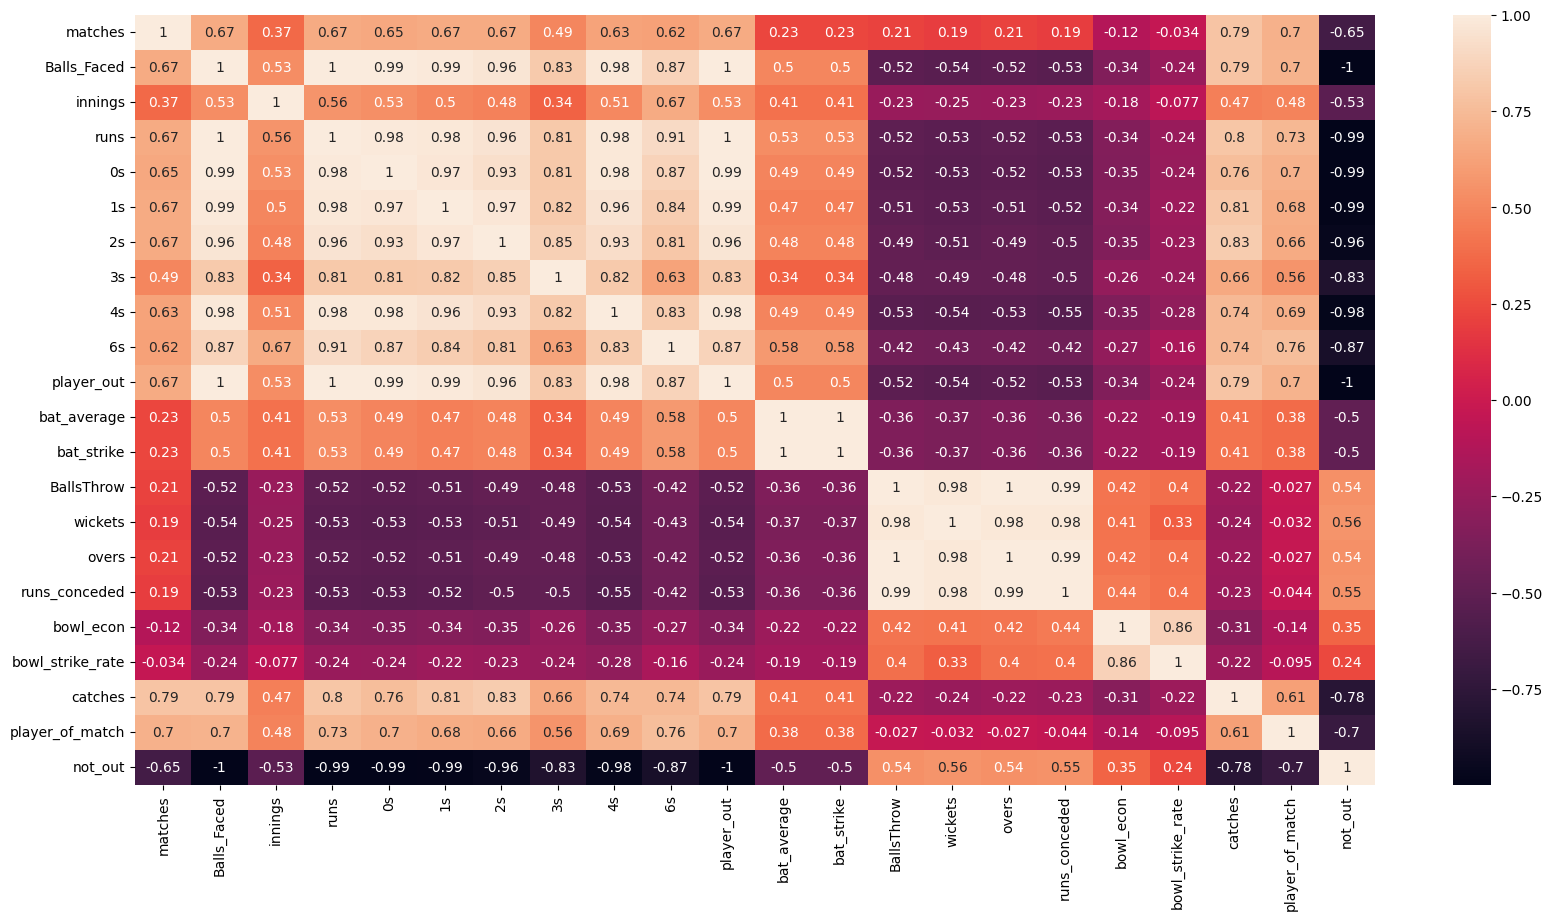

In [68]:
plt.figure(figsize=(20,10))
sns.heatmap(final_df.corr(),annot=True)

In [69]:
def correlation(data, threshold):
    corr_matrix = data.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    col_corr = [col for col in upper_triangle.columns if any(upper_triangle[col] > threshold)]
    return col_corr

In [70]:
corr_cols = correlation(final_df,0.85)
corr_cols

['runs',
 '0s',
 '1s',
 '2s',
 '3s',
 '4s',
 '6s',
 'player_out',
 'bat_strike',
 'wickets',
 'overs',
 'runs_conceded',
 'bowl_strike_rate']

In [71]:
top_columns =final_df.drop(['runs',
 '0s',
 '1s',
 '2s',
 '3s',
 '4s',
 '6s',
 'player_out',
 'wickets',
 'overs',
 'runs_conceded',
 'bowl_strike_rate',
 'not_out'],axis=1)

In [72]:
final_df_new = top_columns[np.isfinite(top_columns).all(1)]
final_df_new.head()

,matches,Balls_Faced,innings,bat_average,bat_strike,BallsThrow,bowl_econ,catches,player_of_match
A Mishra,162.0,440.0,2.0,0.87,86.59,3444.0,7.22,23.0,12.0
A Nehra,88.0,63.0,2.0,0.65,65.08,1974.0,7.58,19.0,6.0
AB Dinda,76.0,50.0,2.0,0.52,52.00,1589.0,7.82,7.0,2.0
AB de Villiers,170.0,3487.0,4.0,1.49,148.58,0.0,0.00,120.0,24.0
AC Gilchrist,80.0,1555.0,2.0,1.33,133.05,1.0,0.00,51.0,7.0


In [73]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(
    scaler.fit_transform(final_df_new),
    columns=top_columns.columns,
    index=final_df_new.index
)
scaled_data.head()

,matches,Balls_Faced,innings,bat_average,bat_strike,BallsThrow,bowl_econ,catches,player_of_match
A Mishra,1.270117,-0.648509,-0.440086,-0.970824,-0.983792,2.052456,0.302994,-0.511771,1.361877
A Nehra,-0.329194,-0.948633,-0.440086,-1.762448,-1.757160,0.757290,0.401280,-0.653499,0.113030
AB Dinda,-0.588542,-0.958983,-0.440086,-2.230227,-2.227436,0.418080,0.466804,-1.078684,-0.719534
AB de Villiers,1.443015,1.777164,2.724343,1.260117,1.244986,-0.981933,-1.668184,2.925141,3.859570
AC Gilchrist,-0.502093,0.239126,-0.440086,0.684390,0.686623,-0.981052,-1.668184,0.480328,0.321171


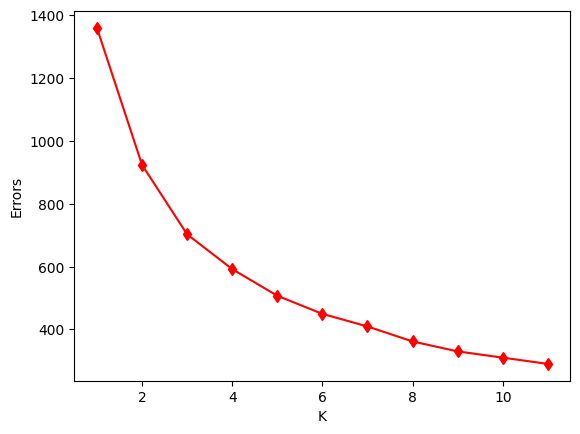

In [74]:
clusters=range(1,12)
errors=[]
for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(scaled_data)
    errors.append(model.inertia_)
plt.xlabel('K')
plt.ylabel('Errors')
plt.plot(clusters,errors,'rd-')

In [75]:
model = KMeans(n_clusters = 4)
y_pred = model.fit_predict(scaled_data)
final_df_new['cluster'] = y_pred

In [76]:
final_df_new.head()

,matches,Balls_Faced,innings,bat_average,bat_strike,BallsThrow,bowl_econ,catches,player_of_match,cluster
A Mishra,162.0,440.0,2.0,0.87,86.59,3444.0,7.22,23.0,12.0,2
A Nehra,88.0,63.0,2.0,0.65,65.08,1974.0,7.58,19.0,6.0,2
AB Dinda,76.0,50.0,2.0,0.52,52.00,1589.0,7.82,7.0,2.0,2
AB de Villiers,170.0,3487.0,4.0,1.49,148.58,0.0,0.00,120.0,24.0,1
AC Gilchrist,80.0,1555.0,2.0,1.33,133.05,1.0,0.00,51.0,7.0,3


In [77]:
final_df_new.reset_index(inplace=True)
topPlayers = final_df_new.rename(columns = {'index':'PlayerNames'})
topPlayers_cluster = pd.DataFrame(topPlayers[['PlayerNames','cluster']])

In [78]:
topPlayers_cluster

,PlayerNames,cluster
0,A Mishra,2
1,A Nehra,2
2,AB Dinda,2
3,AB de Villiers,1
4,AC Gilchrist,3
...,...,...
146,Y Venugopal Rao,0
147,YK Pathan,1
148,YS Chahal,2
149,Yuvraj Singh,0


In [79]:
teams1 = topPlayers_cluster.loc[topPlayers_cluster['cluster']==0]
teams1 = teams1['PlayerNames'].tolist()

teams2 = topPlayers_cluster.loc[topPlayers_cluster['cluster']==1]
teams2 = teams2['PlayerNames'].tolist()

teams3 = topPlayers_cluster.loc[topPlayers_cluster['cluster']==2]
teams3 = teams3['PlayerNames'].tolist()

teams4 = topPlayers_cluster.loc[topPlayers_cluster['cluster']==3]
teams4 = teams4['PlayerNames'].tolist()

In [80]:
TopPlayer_Dataset = pd.DataFrame(teams1,columns=['teams1'])

In [81]:
TopPlayer_Dataset['teams2']=pd.Series(teams2)
TopPlayer_Dataset['teams3']=pd.Series(teams3)
TopPlayer_Dataset['teams4']=pd.Series(teams4)
TopPlayer_Dataset = TopPlayer_Dataset.fillna('')

In [82]:
TopPlayer_Dataset


,teams1,teams2,teams3,teams4
0,AJ Finch,AB de Villiers,A Mishra,AC Gilchrist
1,AM Nayar,AD Russell,A Nehra,BB McCullum
2,AR Patel,AM Rahane,AB Dinda,D Padikkal
3,Abhishek Sharma,AT Rayudu,Arshdeep Singh,DA Miller
4,Avesh Khan,CH Gayle,B Kumar,DPMD Jayawardene
5,BJ Hodge,F du Plessis,CV Varun,EJG Morgan
6,CH Morris,GJ Maxwell,DS Kulkarni,G Gambhir
7,DJ Bravo,HH Pandya,DW Steyn,Ishan Kishan
8,DJ Hooda,KA Pollard,I Sharma,JC Buttler
9,DJ Hussey,KD Karthik,Imran Tahir,KC Sangakkara


In [83]:
matches = pd.read_csv('matches.csv')
balls = pd.read_csv('deliveries.csv')

In [84]:
inningScores = balls.groupby(['match_id', 'inning']).sum()['total_runs'].reset_index()
inningScores = inningScores[inningScores['inning']==1]
inningScores.head(10)

,match_id,inning,total_runs
0,335982,1,222
2,335983,1,240
4,335984,1,129
6,335985,1,165
8,335986,1,110
10,335987,1,166
12,335988,1,142
14,335989,1,208
16,335990,1,214
18,335991,1,182


In [85]:
inningScores['target'] = inningScores['total_runs'] + 1
inningScores.head(10)

,match_id,inning,total_runs,target
0,335982,1,222,223
2,335983,1,240,241
4,335984,1,129,130
6,335985,1,165,166
8,335986,1,110,111
10,335987,1,166,167
12,335988,1,142,143
14,335989,1,208,209
16,335990,1,214,215
18,335991,1,182,183


In [86]:
matches.rename(columns={'id':'match_id'} , inplace = True)

In [87]:
matches = matches.merge(inningScores[['match_id','target']], on='match_id')

In [88]:
matches.head()

,match_id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,target
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,223
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri,241
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar,130
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper,166
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan,111


In [89]:
# Updating the names of the teams as per new names

matches['team1'] = matches['team1'].str.replace('Delhi Daredevils', 'Delhi Capitals')
matches['team2'] = matches['team2'].str.replace('Delhi Daredevils', 'Delhi Capitals')
matches['winner'] = matches['winner'].str.replace('Delhi Daredevils', 'Delhi Capitals')

matches['team1'] = matches['team1'].str.replace('Kings XI Punjab', 'Punjab Kings')
matches['team2'] = matches['team2'].str.replace('Kings XI Punjab', 'Punjab Kings')
matches['winner'] = matches['winner'].str.replace('Kings XI Punjab', 'Punjab Kings')

matches['team1'] = matches['team1'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
matches['team2'] = matches['team2'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
matches['winner'] = matches['winner'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')

matches['team1'] = matches['team1'].str.replace('Rising Pune Supergiant', 'Pune Warriors')
matches['team2'] = matches['team2'].str.replace('Rising Pune Supergiant', 'Pune Warriors')
matches['winner'] = matches['winner'].str.replace('Rising Pune Supergiant', 'Pune Warriors')

matches['team1'] = matches['team1'].str.replace('Rising Pune Supergiants', 'Pune Warriors')
matches['team2'] = matches['team2'].str.replace('Rising Pune Supergiants', 'Pune Warriors')
matches['winner'] = matches['winner'].str.replace('Rising Pune Supergiants', 'Pune Warriors')

matches['team1'] = matches['team1'].str.replace('Gujarat Lions', 'Gujarat Titans')
matches['team2'] = matches['team2'].str.replace('Gujarat Lions', 'Gujarat Titans')
matches['winner'] = matches['winner'].str.replace('Gujarat Lions', 'Gujarat Titans')

In [90]:
teams2024 = [
    'Rajasthan Royals',
    'Royal Challengers Bangalore',
    'Sunrisers Hyderabad',
    'Delhi Capitals',
    'Chennai Super Kings',
    'Gujarat Titans',
    'Lucknow Super Giants',
    'Kolkata Knight Riders',
    'Punjab Kings',
    'Mumbai Indians'
]

In [91]:
matches = matches[matches['team1'].isin(teams2024)]
matches = matches[matches['team2'].isin(teams2024)]
matches = matches[matches['winner'].isin(teams2024)]

In [92]:
matches.team1.unique()

array(['Royal Challengers Bangalore', 'Punjab Kings', 'Delhi Capitals',
       'Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals',
       'Sunrisers Hyderabad', 'Chennai Super Kings', 'Gujarat Titans',
       'Lucknow Super Giants'], dtype=object)

In [93]:
matches.head()

,match_id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,target
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,223
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Punjab Kings,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri,241
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Capitals,Rajasthan Royals,Rajasthan Royals,bat,Delhi Capitals,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar,130
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper,166
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Sunrisers Hyderabad,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan,111


In [94]:
matches.isnull().sum()

match_id             0
season               0
city                51
date                 0
match_type           0
player_of_match      0
venue                0
team1                0
team2                0
toss_winner          0
toss_decision        0
winner               0
result               0
result_margin       14
target_runs          0
target_overs         0
super_over           0
method             970
umpire1              0
umpire2              0
target               0
dtype: int64

In [95]:
matches = matches[['match_id','city','team1','team2','winner','target']].dropna()
matches.head()

,match_id,city,team1,team2,winner,target
0,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223
1,335983,Chandigarh,Punjab Kings,Chennai Super Kings,Chennai Super Kings,241
2,335984,Delhi,Delhi Capitals,Rajasthan Royals,Delhi Capitals,130
3,335985,Mumbai,Mumbai Indians,Royal Challengers Bangalore,Royal Challengers Bangalore,166
4,335986,Kolkata,Kolkata Knight Riders,Sunrisers Hyderabad,Kolkata Knight Riders,111


In [96]:
balls['batting_team'] = balls['batting_team'].str.replace('Delhi Daredevils', 'Delhi Capitals')
balls['batting_team'] = balls['batting_team'].str.replace('Kings XI Punjab', 'Punjab Kings')
balls['batting_team'] = balls['batting_team'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
balls['batting_team'] = balls['batting_team'].str.replace('Rising Pune Supergiant', 'Pune Warriors')
balls['batting_team'] = balls['batting_team'].str.replace('Rising Pune Supergiants', 'Pune Warriors')
balls['batting_team'] = balls['batting_team'].str.replace('Pune Warriorss', 'Pune Warriors')
balls['batting_team'] = balls['batting_team'].str.replace('Gujarat Lions', 'Gujarat Titans')

In [97]:
balls.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [98]:
final = matches.merge(balls, on='match_id')
final.head()

,match_id,city,team1,team2,winner,target,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [99]:
final = final[final['inning']==2]
final.head()

,match_id,city,team1,team2,winner,target,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
124,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN
125,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN
126,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN
127,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN
128,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN


In [100]:
final['current_score'] = final.groupby('match_id')['total_runs'].cumsum()
final.head()

,match_id,city,team1,team2,winner,target,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score
124,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,1
125,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,2
126,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2
127,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,3
128,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,4


In [101]:
final['wickets_left'] = 10 - final.groupby('match_id')['is_wicket'].cumsum()
final.head()

,match_id,city,team1,team2,winner,target,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,wickets_left
124,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,1,10
125,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,2,10
126,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2,10
127,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,3,10
128,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,4,10


In [102]:
final['runs_left'] = np.where(final['target']-final['current_score']>=0, final['target']-final['current_score'], 0)
final.head()

,match_id,city,team1,team2,winner,target,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,wickets_left,runs_left
124,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,1,10,222
125,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,2,10,221
126,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2,10,221
127,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,3,10,220
128,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,4,10,219


In [103]:
final['balls_left'] = np.where(120 - final['over']*6 - final['ball']>=0,120 - final['over']*6 - final['ball'], 0)
final.head()

,match_id,city,team1,team2,winner,target,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,wickets_left,runs_left,balls_left
124,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,1,10,222,119
125,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,2,10,221,118
126,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2,10,221,117
127,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,3,10,220,116
128,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,4,10,219,115


In [104]:
final['current_run_rate'] = (final['current_score']*6)/(120-final['balls_left'])
final['required_run_rate'] = np.where(final['balls_left']>0, final['runs_left']*6/final['balls_left'], 0)

In [105]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

In [106]:
final['result'] = final.apply(result, axis=1)
final.head()

,match_id,city,team1,team2,winner,target,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,wickets_left,runs_left,balls_left,current_run_rate,required_run_rate,result
124,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,1,10,222,119,6.0,11.193277,0
125,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,2,10,221,118,6.0,11.237288,0
126,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2,10,221,117,4.0,11.333333,0
127,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,3,10,220,116,4.5,11.379310,0
128,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,4,10,219,115,4.8,11.426087,0


In [107]:
index1 = final[final['team2'] == final['batting_team']]['team1'].index
index2 = final[final['team1'] == final['batting_team']]['team2'].index
final.loc[index1, 'bowling_team'] = final.loc[index1, 'team1']
final.loc[index2, 'bowling_team'] = final.loc[index2, 'team2']
final.head()

,match_id,city,team1,team2,winner,target,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,current_score,wickets_left,runs_left,balls_left,current_run_rate,required_run_rate,result
124,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,1,10,222,119,6.0,11.193277,0
125,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,2,10,221,118,6.0,11.237288,0
126,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2,10,221,117,4.0,11.333333,0
127,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,3,10,220,116,4.5,11.379310,0
128,335982,Bangalore,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata Knight Riders,223,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,4,10,219,115,4.8,11.426087,0


In [108]:
winningPred = final[['batting_team', 'bowling_team','city','runs_left','balls_left','wickets_left','current_run_rate','required_run_rate','target','result']]
winningPred.head()

,batting_team,bowling_team,city,runs_left,balls_left,wickets_left,current_run_rate,required_run_rate,target,result
124,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,222,119,10,6.0,11.193277,223,0
125,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,221,118,10,6.0,11.237288,223,0
126,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,221,117,10,4.0,11.333333,223,0
127,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,220,116,10,4.5,11.379310,223,0
128,Royal Challengers Bangalore,Kolkata Knight Riders,Bangalore,219,115,10,4.8,11.426087,223,0


In [109]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])
],
remainder = 'passthrough')

In [110]:
X = winningPred.drop('result', axis=1)  # separating the given data and target data to be predicted
y = winningPred['result']
X.shape, y.shape

((107970, 9), (107970,))

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [112]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',RandomForestClassifier())
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [113]:
pipe.predict_proba(X_test)

array([[0.87, 0.13],
       [0.97, 0.03],
       [1.  , 0.  ],
       ...,
       [0.  , 1.  ],
       [0.11, 0.89],
       [0.01, 0.99]])

In [114]:
match_sides = [['Royal Challengers Bangalore', 'Mumbai Indians', 'Mumbai', 108, 49, 6 ,10, 6.5, 200]]
columns = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
       'wickets_left', 'current_run_rate', 'required_run_rate', 'target']

match_data = pd.DataFrame(match_sides,columns=columns)

In [115]:
pipe.predict_proba(match_data)

array([[0.52, 0.48]])

In [116]:
print(winningPred['batting_team'].unique())
print("\n")

batting_team = input( "enter batting team \n" )
bowling_team = input( "enter bowling team \n" )
city = input( "enter city \n" )
runs_left = int(input( "enter runs left \n" ))
balls_left = int(input( "enter balls left \n" ))
wickets_left = int(input( "enter wickets left \n" ))
current_run_rate = float(input( "enter current run rate \n" ))
required_run_rate = float(input( "enter required run rate \n" ))
target = int(input( "enter target \n" ))

match_sides = [[batting_team, bowling_team, city, runs_left, balls_left, wickets_left, current_run_rate, required_run_rate, target]]
columns = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
       'wickets_left', 'current_run_rate', 'required_run_rate', 'target']

match_data = pd.DataFrame( match_sides , columns = columns )

proba_array = pipe.predict_proba(match_data)

print(pipe.predict_proba(match_data))

if(proba_array[0][0]>proba_array[0][1]):
  print( batting_team + " won the match \n" )
else:
  print( bowling_team + " won the match \n")


['Royal Challengers Bangalore' 'Punjab Kings' 'Delhi Capitals'
 'Kolkata Knight Riders' 'Rajasthan Royals' 'Mumbai Indians'
 'Chennai Super Kings' 'Sunrisers Hyderabad' 'Gujarat Titans'
 'Lucknow Super Giants']


enter batting team 
Kolkata Knight Riders
enter bowling team 
Rajasthan Royals
enter city 
Bangalore
enter runs left 
45
enter balls left 
40
enter wickets left 
5
enter current run rate 
3
enter required run rate 
6
enter target 
140
[[0.29 0.71]]
Rajasthan Royals won the match 



In [117]:
class RuleBot:
  negative_responses = ("no", "nope", "nah", "na", "not at all", "never", "no way", "absolutely not", "certainly not", "i don't think so", "i disagree", "not really", "not interested", "don't want to", "negative", "not happening", "unlikely", "by no means", "definitely not", "hardly", "no chance", "out of the question", "not in a million years", "under no circumstances", "forget it", "not now", "not today", "no thanks", "i'm afraid not", "no sir")

  exit_commands = ("quit", "bye", "goodbye", "exit", "see you", "farewell", "later", "ciao", "adios", "au revoir", "take care", "catch you later", "peace out", "sayonara", "so long", "have a nice day", "i'm out", "talk to you later", "all the best", "cheerio")


  random_questions = (
      "How can I help you? \n" ,
      "What crime do you wanna know about? \n",
      "Do you have any specific location in mind? \n" ,
      "Do you feel okay? \n",
      "Can you tell me about yourself? \n"
  )

  def __init__(self):

    self.alienbabble = {
    "player_of_match_intent": r"\b(player\s+of\s+match|player\s+of\s+the\s+match)\b",
    "strike_rate_intent" : r"\b(strike\s+rate)\b",
    "most_catches_intent" : r"\b(most\s+catches|\s*caught\s*|best\s+catches)\b",
    "top_10_batsmen_intent": r"\b(worst\s+batsman|best\s+batsman|top\s+batsman|top\s+scorer|top\s+run\s+scorer|best\s+run\s+scorer)\b",
    "top_10_bowlers_intent": r"\b(worst\s+bowler|best\s+bowler|top\s+bowler|most\s+wickets|top\s+10\s+bowlers|top\s+ten\s+bowlers)\b",
    "prediction_intent": r"\b(prediction|expected\s+outcome|predict\s+)\b"
    }

  def greet(self):
    self.name = input("What is your name? \n")

    will_help = input( f"Hi {self.name} , I am IPL-Bot, do you need my help today? \nI can help with the following stuff:\nFinding Best Batsmen\nFinding Best Bowlers\nFinding Strike Rate\nFinding Most Catches\nFinding Player of the Match\Outcome Prediction of a match\n\nDo you need my help today?\n" )
    if will_help in self.negative_responses or will_help in self.exit_commands:
      print("Okay, Bye! \n")
      return
    self.chat()

  def make_exit(self,reply):
    if reply in self.exit_commands:
      responses = ( "Okay exiting, Bye!\n" , "Okay, see you later, bye-bye!\n" , "Alright, tata!\n" )
      print(random.choice(responses))
      return True

  def match_reply(self,reply):
    for intent, pattern in self.alienbabble.items():
      found = re.search(pattern, reply , re.IGNORECASE)
      if found:
        if intent == "player_of_match_intent":
          return self.get_player_of_match()
        elif intent == "strike_rate_intent":
          return self.get_strike_rate()
        elif intent == "most_catches_intent":
          return self.get_most_catches()
        elif intent == "top_10_batsmen_intent":
          return self.get_top_10_batsmen()
        elif intent == "top_10_bowlers_intent":
          return self.get_top_10_bowlers()
        elif intent == "prediction_intent":
          return self.get_prediction()

    if not found:
      return self.no_match_intent()

  def get_player_of_match(self):
    return pom()

  def get_strike_rate(self):
    return bat_strike()

  def get_most_catches(self):
    return most_catches()

  def get_top_10_batsmen(self):
    return top10batsmen()

  def get_top_10_bowlers(self):
    return top10bowlers()

  def get_prediction(self):
    print(winningPred['batting_team'].unique())
    print("\n")

    batting_team = input( "enter batting team \n" )
    bowling_team = input( "enter bowling team \n" )
    city = input( "enter city \n" )
    runs_left = int(input( "enter runs left \n" ))
    balls_left = int(input( "enter balls left \n" ))
    wickets_left = int(input( "enter wickets left \n" ))
    current_run_rate = float(input( "enter current run rate \n" ))
    required_run_rate = float(input( "enter required run rate \n" ))
    target = int(input( "enter target \n" ))

    match_sides = [[batting_team, bowling_team, city, runs_left, balls_left, wickets_left, current_run_rate, required_run_rate, target]]
    columns = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
          'wickets_left', 'current_run_rate', 'required_run_rate', 'target']

    match_data = pd.DataFrame( match_sides , columns = columns )

    proba_array = pipe.predict_proba(match_data)

    print(pipe.predict_proba(match_data))

    if(proba_array[0][0]>proba_array[0][1]):
      return ( batting_team + " won the match \n" )
    else:
      return ( bowling_team + " won the match \n")

  def no_match_intent(self):
    responses = ( "Please tell me more \n" , "Can you tell me more? \n" , "Wow, what else? \n" )
    return random.choice(responses)

  def chat(self):
    reply = input( random.choice( self.random_questions ) ).lower()
    while not self.make_exit(reply):
      reply = self.match_reply(reply)
      if self.make_exit(reply):
        break
      reply = input(reply)

AlienBot = RuleBot()
AlienBot.greet()

What is your name? 
Ben
Hi Ben , I am IPL-Bot, do you need my help today? 
I can help with the following stuff:
Finding Best Batsmen
Finding Best Bowlers
Finding Strike Rate
Finding Most Catches
Finding Player of the Match\Outcome Prediction of a match

Do you need my help today?
yes please
Do you feel okay? 
yes I do, thanks
Please tell me more 
can you help me find the best batsman


Nonewho was the player of the match


Noneand the best bowler


Nonecan you predict the outcome
['Royal Challengers Bangalore' 'Punjab Kings' 'Delhi Capitals'
 'Kolkata Knight Riders' 'Rajasthan Royals' 'Mumbai Indians'
 'Chennai Super Kings' 'Sunrisers Hyderabad' 'Gujarat Titans'
 'Lucknow Super Giants']


enter batting team 
Gujarat Titans
enter bowling team 
Chennai Super Kings
enter city 
Kolkata
enter runs left 
39
enter balls left 
30
enter wickets left 
6
enter current run rate 
4
enter required run rate 
8
enter target 
175
[[0.33 0.67]]
Chennai Super Kings won the match 
bye
Okay exiting, Bye!

